# Ice rink simulational modeling

#### Imports

In [6]:
import numpy as np
from collections import deque
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

#### Template for customer 

In [2]:
customer_template = {
    'id': 0,
    't_arrived': 0,
    'has_skates': True,
    't_ticket_service': 0,
    't_got_ticket': 0,
    't_rent_service': 0,
    't_got_skates': 0,
    't_change_to_time': 0,
    't_changed_skates': 0,
    't_on_ice': 0,
    't_left_ice_rink': 0,
    't_change_back_time': 0,
    't_changed_back': 0,
    't_to_return_skates': 0,
    't_returned_skates': 0,
    't_left_sharpening': 0,
    't_sharpening': 0
}
cust_id = 0

In [3]:
def new_customer(cust_id, t_arrived, has_skates):
    customer = customer_template.copy()
    customer['t_arrived'] = t_arrived
    customer['has_skates'] = has_skates
    customer['id'] = cust_id
    return customer


def get_normal_servicing_time(m, sigma_2, minv=-1, maxv=-1):
    val = int(np.random.normal(m, sigma_2))
    if minv != -1 and val < minv:
        val = minv
    if maxv != -1 and val > maxv:
        val = maxv
        
    return val

#### Main code for simulation of ice rink

In [4]:
def simulation(n_customers, lambda_1, N_1, N_2, max_time, max_skates, max_ice_capacity, print_log=True):
    mu_1 = 2 * 60 # ticket
    sigma_1 = 1 * 60
    mu_2 = 6 * 60 # rent
    sigma_2 = 1 * 60
    mu_3 = 10 * 60 # sharp
    sigma_3 = 3 * 60
    mu_4 = 10 * 60 # change
    sigma_4 = 3 * 60
    mu_5 = 45 * 60 # on ice  
    sigma_5 = 10 * 60
    mu_6 = 1 * 60 # rent back  
    sigma_6 = 0.3 * 60
    
    alpha = 0.1 # proba of sharpening
    beta = 0.2 # proba of customer has their own skates
    
    customers = []
    n_cust_in_system = 0
    interarrival = np.random.exponential(lambda_1, n_customers - 1) + 1
    arrival = np.zeros(n_customers, dtype=int)
    arrival[0] = 0
    for i in range(1, n_customers):
        arrival[i] = int(arrival[i - 1] + interarrival[i - 1])
    has_skates = np.random.choice(2, n_customers, p=[1 - beta, beta])
    ticket_queue = deque()
    rent_queue = deque()
    sharpening_queue = deque()
    rent_back_queue = deque()
    
    current_n_skates = max_skates
    
    # (time_left, current_customer)
    ticket_office_serving_time_left = np.full((2, N_1), 0, dtype=object)
    ticket_office_serving_time_left[1][:] = None
    
    # (time_left, current_customer)
    rent_serving_time_left = np.full((2, N_2), 0, dtype=object)
    rent_serving_time_left[1][:] = None
    
    sharpening_time_left = [0, None]
    
    change_to_time_left = []
    
    change_back_time_left = []
    
    rent_back_time_left = [0, None]
    
    on_ice_rink = []
    
    gone = []
    
    all_customers = []
    
    n_left_no_skates = 0
    
    n_left_max_ice_capacity_has_skates = 0
    
    n_left_max_ice_capacity_no_skates = 0
    
    current_ice_capacity = 0
    
    ice_capacity = []
    
    for sec in range(max_time):
        log = ''
        # check ticket office arrival
        if len(arrival) > 0 and arrival[0] == sec:
            n_cust_in_system += 1
            new_c = new_customer(n_cust_in_system, arrival[0], has_skates[0])
            all_customers.append(new_c)
            ticket_queue.append(new_c)
            log += '{0} arrived in system\n'.format(new_c.get('id'))
            arrival = arrival[1:]
            has_skates = has_skates[1:]
        
        # check how many ticket offices are open 
        # and move queue if there are at least one open
        open_office = np.argwhere(ticket_office_serving_time_left[0][:] == 0)
        for i in range(min(len(ticket_queue), len(open_office))):
            serving_time = get_normal_servicing_time(mu_1, sigma_1, 1 * 60, -1)
            current_customer = ticket_queue.popleft()
            log += 'start serving {0} in {1} ticket office, serving time {2}\n'.format(current_customer.get('id'), open_office[i], serving_time)
            ticket_office_serving_time_left[0][open_office[i]] = serving_time
            ticket_office_serving_time_left[1][open_office[i]] = current_customer
            current_customer['t_ticket_service'] = serving_time
            
        # tick time for ticket office
        customers_with_tickets = []
        for i in range(len(ticket_office_serving_time_left[0])):
            
            # if office is busy
            if ticket_office_serving_time_left[0][i] != 0:
                ticket_office_serving_time_left[0][i] -= 1
                
                # if office is open now
                if ticket_office_serving_time_left[0][i] == 0:
                    log += 'ticket office {0} is now open\n'.format(i)
                    in_i = ticket_office_serving_time_left[1][i]
                    ticket_office_serving_time_left[1][i] = None
                    in_i['t_got_ticket'] = sec
                    log += 'customer {0} got ticket\n'.format(in_i.get('id'))
                    customers_with_tickets.append(in_i)
    
    
        customers_ready_to_change = []
        # send customers with tickets to rent or sharpening
        for i in range(len(customers_with_tickets)):
            if customers_with_tickets[i]['has_skates']:
                proba = np.random.choice(2, 1, p=[1 - alpha, alpha])
                if proba == 1:
                    log += 'customer {0} goes to sharpening\n'.format(customers_with_tickets[i].get('id'))
                    sharpening_queue.append(customers_with_tickets[i])
                else:
                    customers_ready_to_change.append(customers_with_tickets[i])
            else:
                log += 'customer {0} goes to skates rental\n'.format(customers_with_tickets[i].get('id'))
                if len(rent_queue) < current_n_skates:
                    log += '>>> skates left: {0}\n'.format(current_n_skates)
                    rent_queue.append(customers_with_tickets[i])
                else:
                    n_left_no_skates += 1
                    customers_with_tickets[i]['t_rent_service'] = -1
        
        
        # check rent queue
        
        # check how many rent offices are open 
        # and move queue if there are at least one open
        open_rent = np.argwhere(rent_serving_time_left[0][:] == 0)
        for i in range(min(len(rent_queue), len(open_rent))):
            serving_time = get_normal_servicing_time(mu_2, sigma_2, 1 * 60, -1)
            current_customer = rent_queue.popleft()
            rent_serving_time_left[0][open_rent[i]] = serving_time
            rent_serving_time_left[1][open_rent[i]] = current_customer
            current_n_skates -= 1
            log += 'start serving {0} in {1} rent, serving time {2}\n'.format(current_customer.get('id'), open_rent[i], serving_time)
            current_customer['t_rent_service'] = serving_time
            
        # tick time for rent office
        for i in range(len(rent_serving_time_left[0])):
            
            # if rent is busy
            if rent_serving_time_left[0][i] != 0:
                rent_serving_time_left[0][i] -= 1
                
                # if rent is open now
                if rent_serving_time_left[0][i] == 0:
                    in_i = rent_serving_time_left[1][i]
                    rent_serving_time_left[1][i] = None
                    in_i['t_got_skates'] = sec
                    log += 'customer {0} got skates\n'.format(in_i.get('id'))
                    customers_ready_to_change.append(in_i)
        
        # sharpening
        if sharpening_time_left[0] == 0 and len(sharpening_queue) > 0:
            current_customer = sharpening_queue.popleft()
            serving_time = get_normal_servicing_time(mu_3, sigma_3, 5 * 60, -1)
            current_customer['t_sharpening'] = serving_time
            sharpening_time_left[0] = serving_time
            sharpening_time_left[1] = current_customer
        
        # tick time for sharpening
        if sharpening_time_left[0] > 0:
            sharpening_time_left[0] -= 1
            if sharpening_time_left[0] == 0:
                in_sharp = sharpening_time_left[1]
                sharpening_time_left[1] = None
                in_sharp['t_left_sharpening'] = sec
                log += 'customer {0} got skates sharpened\n'.format(in_sharp.get('id'))
                customers_ready_to_change.append(in_sharp)
        
        # change to skates
        for i in range(len(customers_ready_to_change)):
            serving_time = get_normal_servicing_time(mu_4, sigma_4, 2 * 60, -1)
            customers_ready_to_change[i]['t_change_to_time'] = serving_time
            log += 'customer {0} in changing room, time to change {1}\n'.format(customers_ready_to_change[i].get('id'), serving_time)
            change_to_time_left.append(customers_ready_to_change[i])
        
        # check for ready to skate
        ready_to_skate = []
        for i in range(len(change_to_time_left)):
            customer = change_to_time_left[i]
            is_ready = False
            if customer['has_skates'] and customer['t_got_ticket'] + customer['t_sharpening'] + customer['t_change_to_time'] == sec:
                customer['t_changed_skates'] = sec
                ready_to_skate.append(customer)
                log += 'customer {0} is ready for skating\n'.format(customer.get('id'))
                
            if (not customer['has_skates']) and customer['t_got_skates'] + customer['t_change_to_time'] == sec:
                customer['t_changed_skates'] = sec
                ready_to_skate.append(customer)
                log += 'customer {0} is ready for skating\n'.format(customer.get('id'))
        
        for i in range(len(ready_to_skate)):
            change_to_time_left.remove(ready_to_skate[i])
            
        # send ready to skate to ice rink
        for i in range(len(ready_to_skate)):
            if current_ice_capacity < max_ice_capacity:
                serving_time = get_normal_servicing_time(mu_5, sigma_5, 10 * 60, 60 * 60)
                serving_time = 0 if sec >= max_time - 1 else serving_time
                ready_to_skate[i]['t_on_ice'] = serving_time
                on_ice_rink.append(ready_to_skate[i])
                current_ice_capacity += 1
                ice_capacity.append([sec, current_ice_capacity])
                log += 'customer {0} went to ice rink, skate time {1}\n'.format(on_ice_rink[i].get('id'), serving_time)
            else:
                if ready_to_skate[i]['has_skates']:
                    n_left_max_ice_capacity_has_skates += 1
                    ready_to_skate[i]['t_on_ice'] = -1
                else:
                    n_left_max_ice_capacity_no_skates += 1
                    ready_to_skate[i]['t_on_ice'] = -1
                    
        # check for customers on ice with expired time on ice
        to_remove_from_ice = []
        for i in range(len(on_ice_rink)):
            if on_ice_rink[i]['t_changed_skates'] + on_ice_rink[i]['t_on_ice'] == sec or sec == max_time - 1:
                # goes to change room
                current_ice_capacity -= 1
                ice_capacity.append([sec, current_ice_capacity])
                log += 'customer {0} left ice rink\n'.format(on_ice_rink[i].get('id'))
                on_ice_rink[i]['t_left_ice_rink'] = sec
                on_ice_rink[i]['t_change_back_time'] = get_normal_servicing_time(mu_4, sigma_4, 2 * 60, -1)
                on_ice_rink[i]['t_changed_back'] = sec + on_ice_rink[i]['t_change_back_time']
                log += 'customer {0} will change back at {1}\n'.format(on_ice_rink[i].get('id'), on_ice_rink[i].get('t_changed_back'))
                
                # consider customer with his skates gone
                # with rental - they are to return skates
                if on_ice_rink[i]['has_skates'] or (not on_ice_rink[i]['has_skates'] and on_ice_rink[i]['t_changed_back'] >= max_time):
                    gone.append(on_ice_rink[i])
                else:
                    change_back_time_left.append(on_ice_rink[i])
                to_remove_from_ice.append(on_ice_rink[i])
        
        for i in range(len(to_remove_from_ice)):
            on_ice_rink.remove(to_remove_from_ice[i])
        

        # in change_back_time_left only customers with rental skates
        # who return skates before rink is closed
        for i in range(len(change_back_time_left)):
            if change_back_time_left[i]['t_changed_back'] == sec:
                rent_back_queue.append(change_back_time_left[i])
        
        if rent_back_time_left[1] == None and len(rent_back_queue) > 0:
            current_customer = rent_back_queue.popleft()
            serving_time = get_normal_servicing_time(mu_6, sigma_6, int(0.5 * 60), -1)
            rent_back_time_left[0] = serving_time + current_customer['t_changed_back']
            current_customer['t_to_return_skates'] = serving_time
            current_customer['t_returned_skates'] = serving_time + current_customer['t_changed_back']
            rent_back_time_left[1] = current_customer
        
        if rent_back_time_left[1] != None and rent_back_time_left[0] >= sec:
            gone.append(rent_back_time_left[1])
            rent_back_time_left[0] = 0
            rent_back_time_left[1] = None
            current_n_skates += 1
        
        if len(log) > 0 and print_log:
            print('\n' + '-'*10)
            print('now {0}'.format(sec))
            print(log)
    
    in_ticket = ticket_office_serving_time_left[1]
    in_ticket = in_ticket[in_ticket != None]
    for i in range(len(in_ticket)):
        ticket_queue.append(in_ticket[i])
    
    in_rent = rent_serving_time_left[1]
    in_rent = in_rent[in_rent != None]
    for i in range(len(in_rent)):
        rent_queue.append(in_rent[i])
    
    in_sharp = sharpening_time_left[1]
    if in_sharp != None:
        sharpening_queue.append(in_sharp)
    
    return all_customers, ice_capacity



#### Example of work

In [415]:
all_customers, ice_capacity = simulation(400, 60, 2, 2, 12 * 60 * 60, 20, 0, False)

In [417]:
c = pd.DataFrame(all_customers)
c

,id,t_arrived,has_skates,t_ticket_service,t_got_ticket,t_rent_service,t_got_skates,t_change_to_time,t_changed_skates,t_on_ice,t_left_ice_rink,t_change_back_time,t_changed_back,t_to_return_skates,t_returned_skates,t_left_sharpening,t_sharpening
0,1,0,0,115,114,404,517,751,1268,-1,0,0,0,0,0,0,0
1,2,82,0,107,188,323,840,635,1475,-1,0,0,0,0,0,0,0
2,3,86,0,60,174,411,584,354,938,-1,0,0,0,0,0,0,0
3,4,197,0,142,338,474,1058,548,1606,-1,0,0,0,0,0,0,0
4,5,220,0,189,408,362,1202,1289,2491,-1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,24719,0,60,25317,-1,0,0,0,0,0,0,0,0,0,0,0
396,397,24797,1,244,25523,0,0,770,26293,-1,0,0,0,0,0,0,0
397,398,24833,0,60,25377,-1,0,0,0,0,0,0,0,0,0,0,0
398,399,24863,0,126,25503,-1,0,0,0,0,0,0,0,0,0,0,0


### Exploring outcomes

How arrival density affects income, number of fully served customers, nuber of gone customers, average time spent in system?

In [55]:
lambda_1 = np.arange(30, 60*15, 30, dtype=int)
ticket_price = 200
rent_price = 300

stats = []

for l in lambda_1:
    avg_income = 0
    avg_customers_served = 0
    avg_customers_left = 0
    avg_time_spent = 0
    for i in range(5):
        all_customers, ice_capacity = simulation(10000, l, 3, 2, 12 * 60 * 60, 50, 40, False)
        cust_data = pd.DataFrame(all_customers)

        # cumulative income
        income = 0
        income += (cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_on_ice'] > 0)].shape[0]) * rent_price
        income += (cust_data[(cust_data['t_on_ice'] > 0)].shape[0]) * ticket_price
        avg_income += income
        
        served = cust_data[cust_data['t_on_ice'] > 0].shape[0]
        avg_customers_served += served
        avg_customers_left += cust_data.shape[0] - served
        
        no_skates = cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_returned_skates'] > 0)]
        with_skates = cust_data[(cust_data['has_skates'] == 1) & (cust_data['t_changed_back'] > 0)]
        all_to = no_skates['t_returned_skates'] - no_skates['t_arrived']
        all_to = all_to.append(with_skates['t_changed_back'] - with_skates['t_arrived'])
        avg_time_spent += np.mean(all_to)

    avg_income /= 5
    avg_customers_served /= 5
    avg_customers_left /= 5
    avg_time_spent /= 5
    
    stat = {
        'lambda' : l,
        'avg_income': avg_income,
        'avg_customers_served': avg_customers_served,
        'avg_customers_left': avg_customers_left,
        'avg_time_spent': avg_time_spent
    }
    
    stats.append(stat)

stats_data = pd.DataFrame(stats)

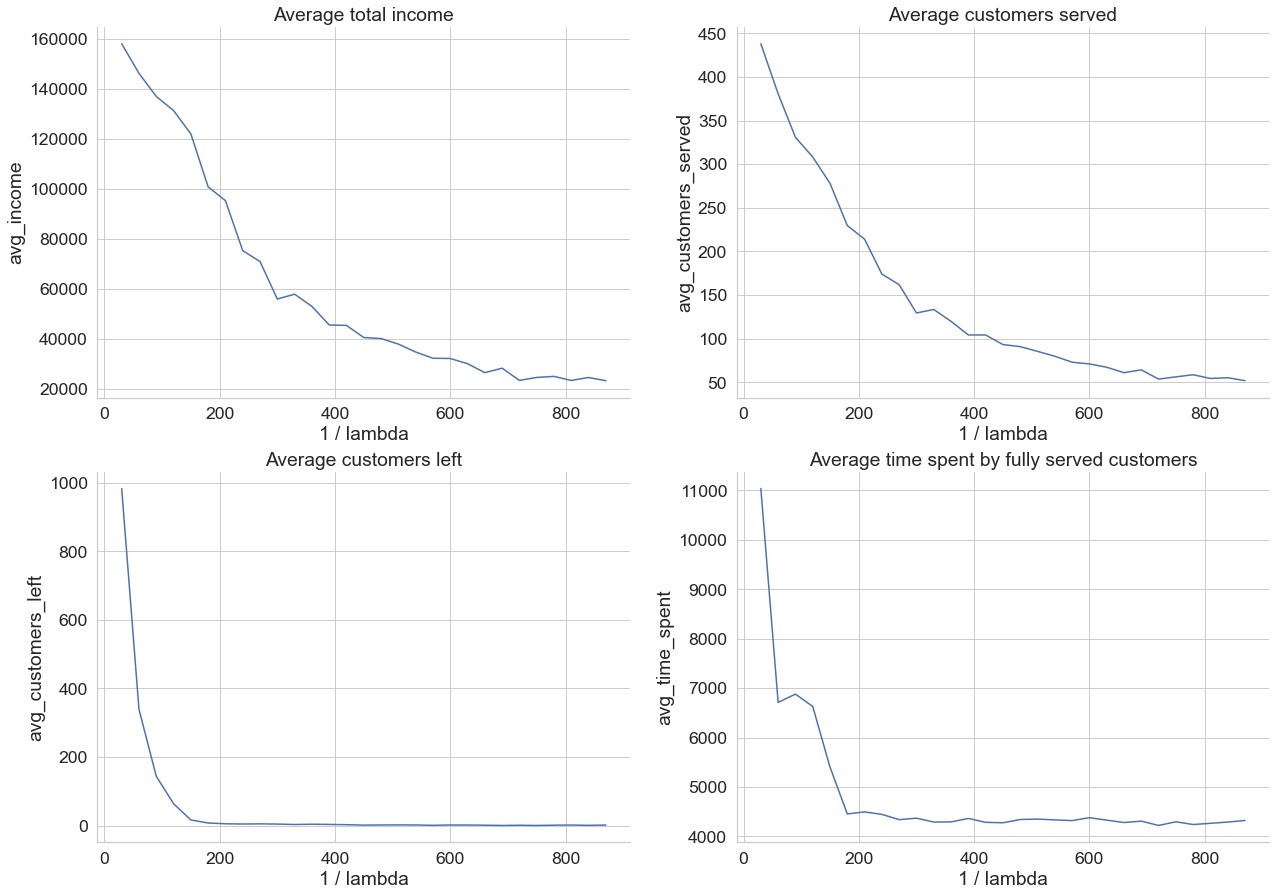

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(21, 15))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')

sns.lineplot(x=stats_data['lambda'], y=stats_data['avg_income'], ax=axs[0][0])
axs[0][0].set_title('Average total income')
axs[0][0].set_xlabel('1 / lambda')

sns.lineplot(x=stats_data['lambda'], y=stats_data['avg_customers_served'], ax=axs[0][1])
axs[0][1].set_title('Average customers served')
axs[0][1].set_xlabel('1 / lambda')

sns.lineplot(x=stats_data['lambda'], y=stats_data['avg_customers_left'], ax=axs[1][0])
axs[1][0].set_title('Average customers left')
axs[1][0].set_xlabel('1 / lambda')

sns.lineplot(x=stats_data['lambda'], y=stats_data['avg_time_spent'], ax=axs[1][1])
axs[1][1].set_title('Average time spent by fully served customers')
axs[1][1].set_xlabel('1 / lambda')

sns.despine()
plt.show()

How ice rink capacity affects income, number of fully served customers, nuber of gone customers, average time spent in system?

In [58]:
capacity = np.arange(10, 120, 5, dtype=int)
ticket_price = 200
rent_price = 300

stats = []

for c in capacity:
    avg_income = 0
    avg_customers_served = 0
    avg_customers_left = 0
    avg_time_spent = 0
    for i in range(5):
        all_customers, ice_capacity = simulation(10000, 60, 3, 2, 12 * 60 * 60, 50, c, False)
        cust_data = pd.DataFrame(all_customers)

        # cumulative income
        income = 0
        income += (cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_on_ice'] > 0)].shape[0]) * rent_price
        income += (cust_data[(cust_data['t_on_ice'] > 0)].shape[0]) * ticket_price
        avg_income += income
        
        served = cust_data[cust_data['t_on_ice'] > 0].shape[0]
        avg_customers_served += served
        avg_customers_left += cust_data.shape[0] - served
        
        no_skates = cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_returned_skates'] > 0)]
        with_skates = cust_data[(cust_data['has_skates'] == 1) & (cust_data['t_changed_back'] > 0)]
        all_to = no_skates['t_returned_skates'] - no_skates['t_arrived']
        all_to = all_to.append(with_skates['t_changed_back'] - with_skates['t_arrived'])
        avg_time_spent += np.mean(all_to)

    avg_income /= 5
    avg_customers_served /= 5
    avg_customers_left /= 5
    avg_time_spent /= 5
    
    stat = {
        'capacity' : c,
        'avg_income': avg_income,
        'avg_customers_served': avg_customers_served,
        'avg_customers_left': avg_customers_left,
        'avg_time_spent': avg_time_spent
    }
    
    stats.append(stat)

stats_data = pd.DataFrame(stats)

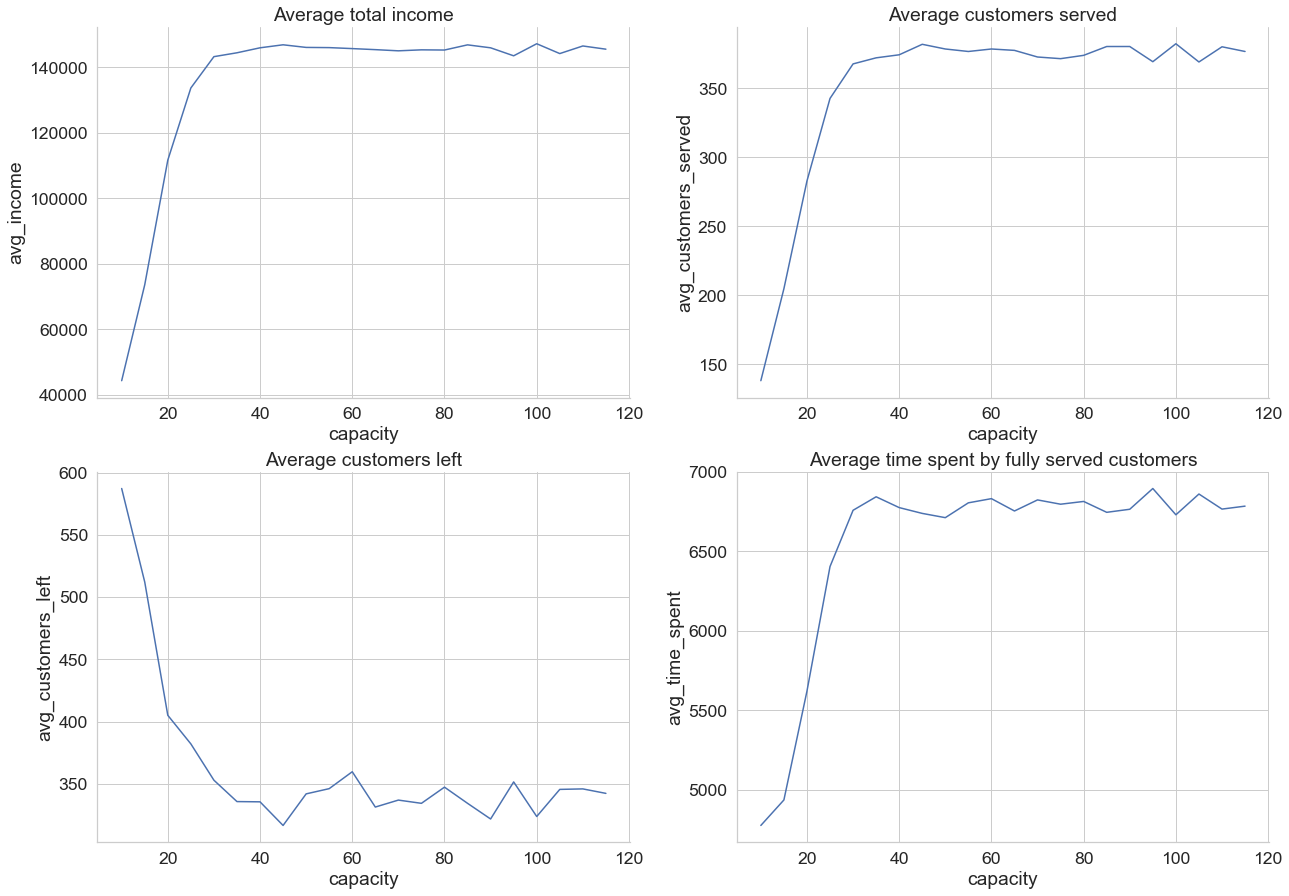

In [59]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(21, 15))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
sns.lineplot(x=stats_data['capacity'], y=stats_data['avg_income'], ax=axs[0][0])
axs[0][0].set_title('Average total income')

sns.lineplot(x=stats_data['capacity'], y=stats_data['avg_customers_served'], ax=axs[0][1])
axs[0][1].set_title('Average customers served')

sns.lineplot(x=stats_data['capacity'], y=stats_data['avg_customers_left'], ax=axs[1][0])
axs[1][0].set_title('Average customers left')

sns.lineplot(x=stats_data['capacity'], y=stats_data['avg_time_spent'], ax=axs[1][1])
axs[1][1].set_title('Average time spent by fully served customers')

sns.despine()
plt.show()

How number of ticket offices affects income, number of fully served customers, nuber of gone customers, average time spent in system?

In [60]:
ticket_offices = np.arange(1, 11, 1, dtype=int)
ticket_price = 200
rent_price = 300

stats = []

for t in ticket_offices:
    avg_income = 0
    avg_customers_served = 0
    avg_customers_left = 0
    avg_time_spent = 0
    for i in range(5):
        all_customers, ice_capacity = simulation(10000, 60, t, 2, 12 * 60 * 60, 50, 35, False)
        cust_data = pd.DataFrame(all_customers)

        # cumulative income
        income = 0
        income += (cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_on_ice'] > 0)].shape[0]) * rent_price
        income += (cust_data[(cust_data['t_on_ice'] > 0)].shape[0]) * ticket_price
        avg_income += income
        
        served = cust_data[cust_data['t_on_ice'] > 0].shape[0]
        avg_customers_served += served
        avg_customers_left += cust_data.shape[0] - served
        
        no_skates = cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_returned_skates'] > 0)]
        with_skates = cust_data[(cust_data['has_skates'] == 1) & (cust_data['t_changed_back'] > 0)]
        all_to = no_skates['t_returned_skates'] - no_skates['t_arrived']
        all_to = all_to.append(with_skates['t_changed_back'] - with_skates['t_arrived'])
        avg_time_spent += np.mean(all_to)

    avg_income /= 5
    avg_customers_served /= 5
    avg_customers_left /= 5
    avg_time_spent /= 5
    
    stat = {
        'ticket_office' : t,
        'avg_income': avg_income,
        'avg_customers_served': avg_customers_served,
        'avg_customers_left': avg_customers_left,
        'avg_time_spent': avg_time_spent
    }
    
    stats.append(stat)

stats_data = pd.DataFrame(stats)

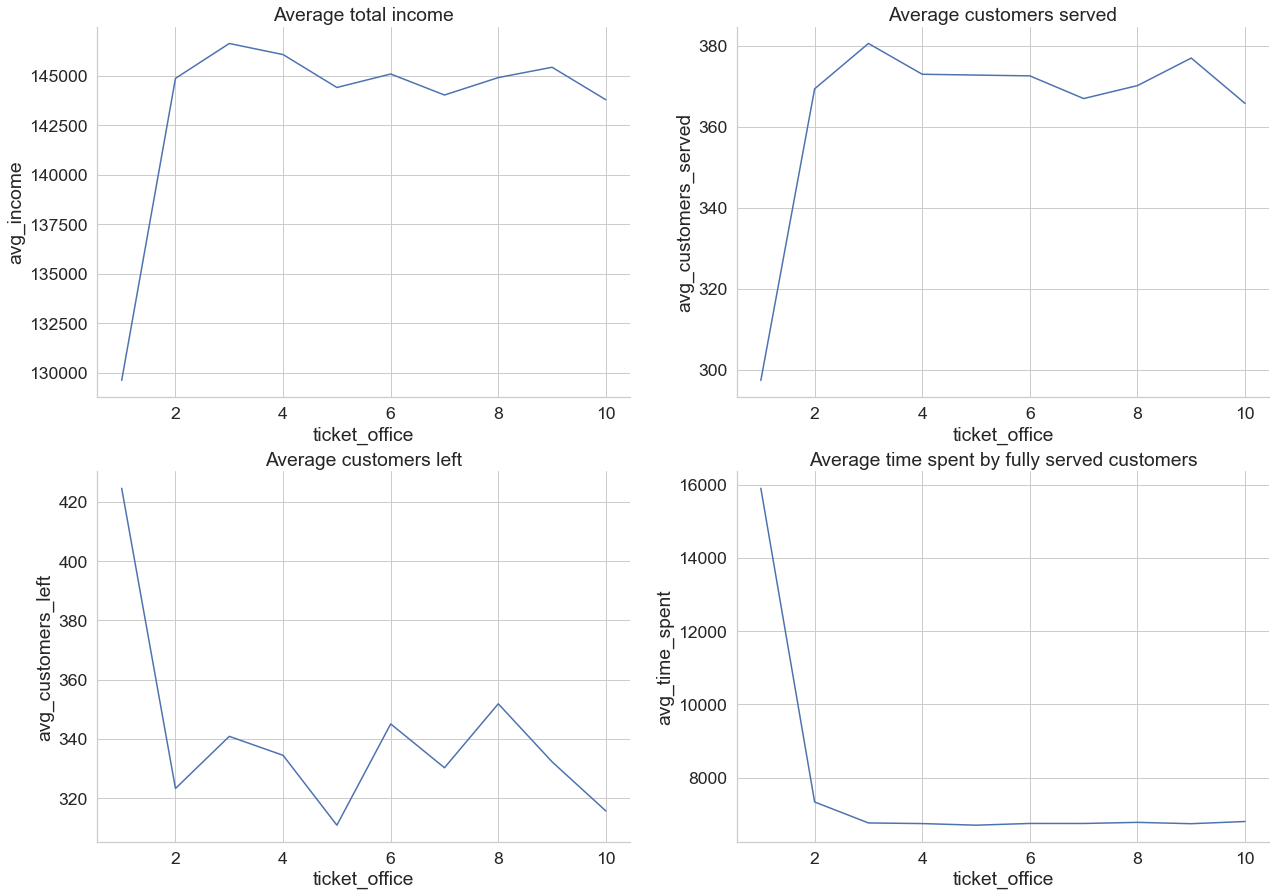

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(21, 15))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
sns.lineplot(x=stats_data['ticket_office'], y=stats_data['avg_income'], ax=axs[0][0])
axs[0][0].set_title('Average total income')

sns.lineplot(x=stats_data['ticket_office'], y=stats_data['avg_customers_served'], ax=axs[0][1])
axs[0][1].set_title('Average customers served')

sns.lineplot(x=stats_data['ticket_office'], y=stats_data['avg_customers_left'], ax=axs[1][0])
axs[1][0].set_title('Average customers left')

sns.lineplot(x=stats_data['ticket_office'], y=stats_data['avg_time_spent'], ax=axs[1][1])
axs[1][1].set_title('Average time spent by fully served customers')

sns.despine()
plt.show()

How number of rent offices affects income, number of fully served customers, nuber of gone customers, average time spent in system?

In [62]:
rent_offices = np.arange(1, 11, 1, dtype=int)
ticket_price = 200
rent_price = 300

stats = []

for r in rent_offices:
    avg_income = 0
    avg_customers_served = 0
    avg_customers_left = 0
    avg_time_spent = 0
    for i in range(5):
        all_customers, ice_capacity = simulation(10000, 60, 3, r, 12 * 60 * 60, 50, 35, False)
        cust_data = pd.DataFrame(all_customers)

        # cumulative income
        income = 0
        income += (cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_on_ice'] > 0)].shape[0]) * rent_price
        income += (cust_data[(cust_data['t_on_ice'] > 0)].shape[0]) * ticket_price
        avg_income += income
        
        served = cust_data[cust_data['t_on_ice'] > 0].shape[0]
        avg_customers_served += served
        avg_customers_left += cust_data.shape[0] - served
        
        no_skates = cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_returned_skates'] > 0)]
        with_skates = cust_data[(cust_data['has_skates'] == 1) & (cust_data['t_changed_back'] > 0)]
        all_to = no_skates['t_returned_skates'] - no_skates['t_arrived']
        all_to = all_to.append(with_skates['t_changed_back'] - with_skates['t_arrived'])
        avg_time_spent += np.mean(all_to)

    avg_income /= 5
    avg_customers_served /= 5
    avg_customers_left /= 5
    avg_time_spent /= 5
    
    stat = {
        'rent_offices' : r,
        'avg_income': avg_income,
        'avg_customers_served': avg_customers_served,
        'avg_customers_left': avg_customers_left,
        'avg_time_spent': avg_time_spent
    }
    
    stats.append(stat)

stats_data = pd.DataFrame(stats)

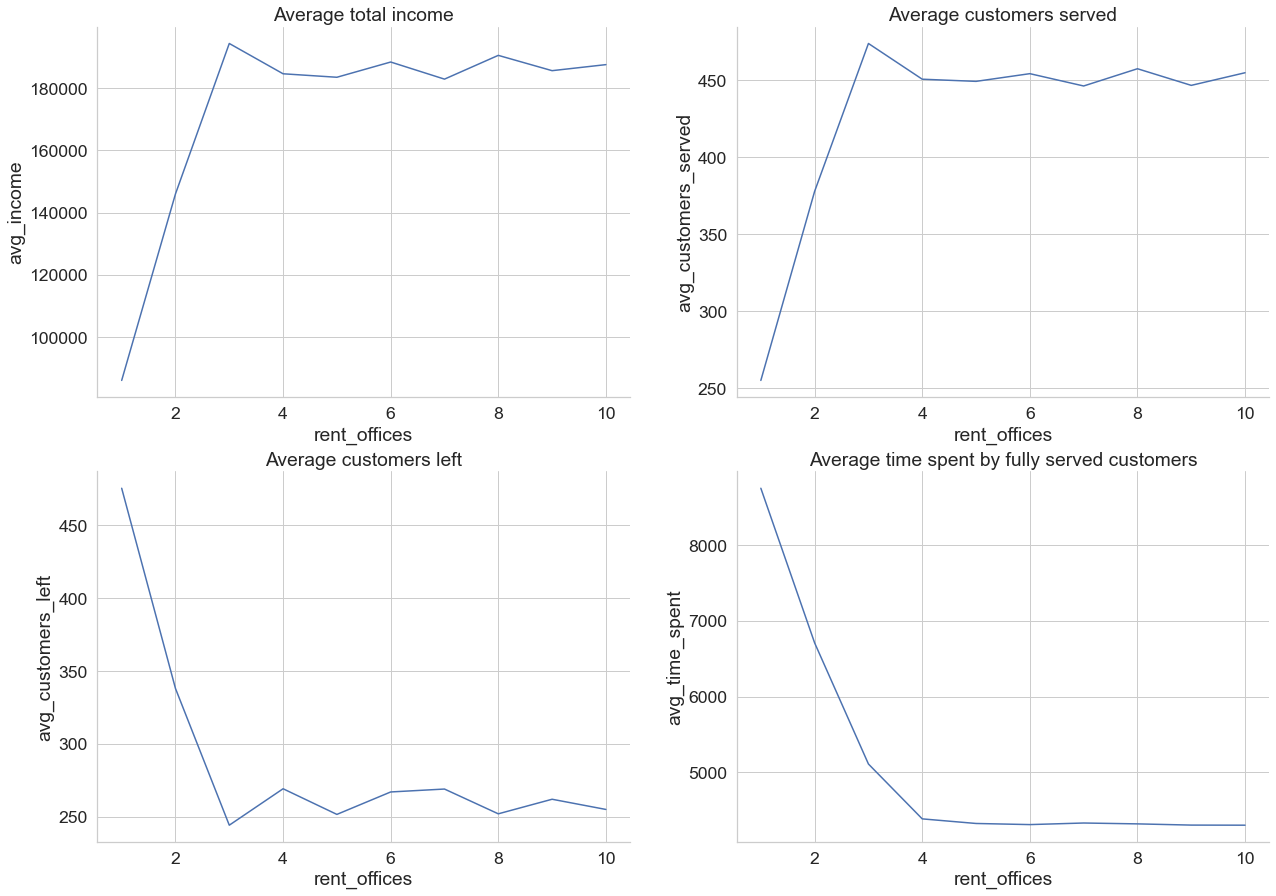

In [63]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(21, 15))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
sns.lineplot(x=stats_data['rent_offices'], y=stats_data['avg_income'], ax=axs[0][0])
axs[0][0].set_title('Average total income')

sns.lineplot(x=stats_data['rent_offices'], y=stats_data['avg_customers_served'], ax=axs[0][1])
axs[0][1].set_title('Average customers served')

sns.lineplot(x=stats_data['rent_offices'], y=stats_data['avg_customers_left'], ax=axs[1][0])
axs[1][0].set_title('Average customers left')

sns.lineplot(x=stats_data['rent_offices'], y=stats_data['avg_time_spent'], ax=axs[1][1])
axs[1][1].set_title('Average time spent by fully served customers')

sns.despine()
plt.show()

How number of skates pairs in rent affects income, number of fully served customers, nuber of gone customers, average time spent in system?

In [64]:
pairs = np.arange(10, 200, 10, dtype=int)
ticket_price = 200
rent_price = 300

stats = []

for p in pairs:
    avg_income = 0
    avg_customers_served = 0
    avg_customers_left = 0
    avg_time_spent = 0
    for i in range(5):
        all_customers, ice_capacity = simulation(10000, 60, 3, 2, 12 * 60 * 60, p, 35, False)
        cust_data = pd.DataFrame(all_customers)

        # cumulative income
        income = 0
        income += (cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_on_ice'] > 0)].shape[0]) * rent_price
        income += (cust_data[(cust_data['t_on_ice'] > 0)].shape[0]) * ticket_price
        avg_income += income
        
        served = cust_data[cust_data['t_on_ice'] > 0].shape[0]
        avg_customers_served += served
        avg_customers_left += cust_data.shape[0] - served
        
        no_skates = cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_returned_skates'] > 0)]
        with_skates = cust_data[(cust_data['has_skates'] == 1) & (cust_data['t_changed_back'] > 0)]
        all_to = no_skates['t_returned_skates'] - no_skates['t_arrived']
        all_to = all_to.append(with_skates['t_changed_back'] - with_skates['t_arrived'])
        avg_time_spent += np.mean(all_to)

    avg_income /= 5
    avg_customers_served /= 5
    avg_customers_left /= 5
    avg_time_spent /= 5
    
    stat = {
        'pairs' : p,
        'avg_income': avg_income,
        'avg_customers_served': avg_customers_served,
        'avg_customers_left': avg_customers_left,
        'avg_time_spent': avg_time_spent
    }
    
    stats.append(stat)

stats_data = pd.DataFrame(stats)

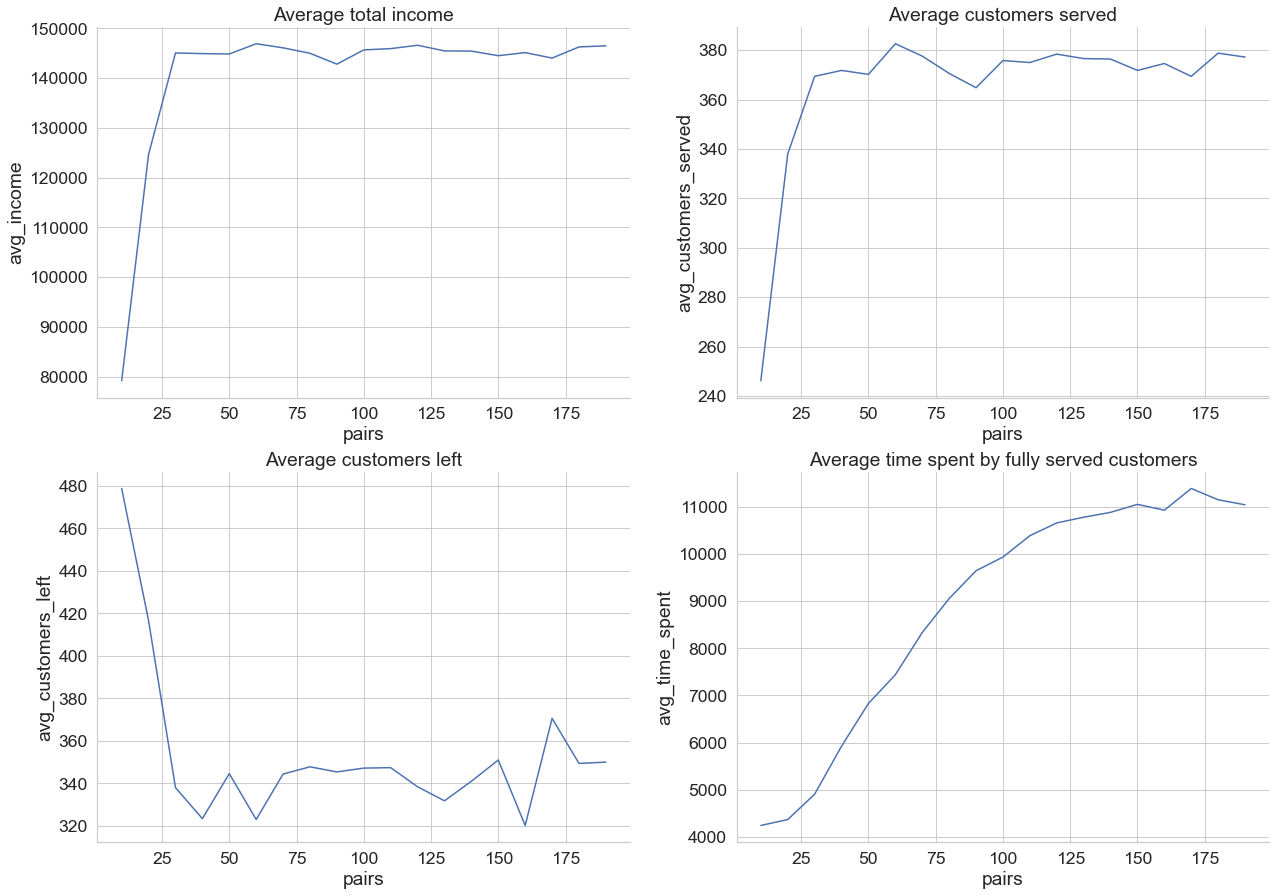

In [65]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(21, 15))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
sns.lineplot(x=stats_data['pairs'], y=stats_data['avg_income'], ax=axs[0][0])
axs[0][0].set_title('Average total income')

sns.lineplot(x=stats_data['pairs'], y=stats_data['avg_customers_served'], ax=axs[0][1])
axs[0][1].set_title('Average customers served')

sns.lineplot(x=stats_data['pairs'], y=stats_data['avg_customers_left'], ax=axs[1][0])
axs[1][0].set_title('Average customers left')

sns.lineplot(x=stats_data['pairs'], y=stats_data['avg_time_spent'], ax=axs[1][1])
axs[1][1].set_title('Average time spent by fully served customers')

sns.despine()
plt.show()

Which capacity of ice rink is the best and the worst for a set of arrival densities?

In [25]:
lambda_1 = np.arange(30, 60*15, 30, dtype=int)
ticket_price = 200
rent_price = 300
capacity = np.arange(10, 120, 5, dtype=int)

for l in lambda_1:
    for c in capacity:
        for i in range(5):
            all_customers, ice_capacity = simulation(10000, l, 3, 3, 12 * 60 * 60, c, 35, False)
            cust_data = pd.DataFrame(all_customers)

            # cumulative income
            income = 0
            income += (cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_on_ice'] > 0)].shape[0]) * rent_price
            income += (cust_data[(cust_data['t_on_ice'] > 0)].shape[0]) * ticket_price
            avg_income += income

            served = cust_data[cust_data['t_on_ice'] > 0].shape[0]
            avg_customers_served += served
            avg_customers_left += cust_data.shape[0] - served

            no_skates = cust_data[(cust_data['has_skates'] == 0) & (cust_data['t_returned_skates'] > 0)]
            with_skates = cust_data[(cust_data['has_skates'] == 1) & (cust_data['t_changed_back'] > 0)]
            all_to = no_skates['t_returned_skates'] - no_skates['t_arrived']
            all_to = all_to.append(with_skates['t_changed_back'] - with_skates['t_arrived'])
            avg_time_spent += np.mean(all_to)

        avg_income /= 5
        avg_customers_served /= 5
        avg_customers_left /= 5
        avg_time_spent /= 5

        stat = {
            'capacity' : c,
            'lambda': l,
            'avg_income': avg_income,
            'avg_customers_served': avg_customers_served,
            'avg_customers_left': avg_customers_left,
            'avg_time_spent': avg_time_spent
        }

        stats.append(stat)

stats_data = pd.DataFrame(stats)


In [33]:
two_d_stats = stats_data[stats_data['pairs'].isnull()]

In [35]:
two_d_stats

,pairs,avg_income,avg_customers_served,avg_customers_left,avg_time_spent,capacity,lambda
19,NaN,118612.000000,371.000000,1179.200000,11473.823415,10.0,30.0
20,NaN,138962.400000,423.600000,1323.040000,11881.829347,15.0,30.0
21,NaN,163072.480000,473.120000,1258.408000,11163.604894,20.0,30.0
22,NaN,184194.496000,516.824000,1250.281600,11669.368986,25.0,30.0
23,NaN,200418.899200,543.564800,1176.456320,11192.654859,30.0,30.0
...,...,...,...,...,...,...,...
652,NaN,27443.631823,62.975684,1.954769,5443.966828,95.0,870.0
653,NaN,26788.726365,60.595137,1.390954,5365.154729,100.0,870.0
654,NaN,25417.745273,58.119027,2.078191,5355.075391,105.0,870.0
655,NaN,27023.549055,61.623805,2.015638,5382.210333,110.0,870.0


In [39]:
a = two_d_stats.sort_values(['avg_income', 'capacity'], ascending=[False, True]).groupby('lambda').first()

In [43]:
a['lambda'] = a.index

In [67]:
b = two_d_stats.sort_values(['avg_customers_served', 'capacity'], ascending=[False, True]).groupby('lambda').first()

In [69]:
b['lambda'] = b.index
b

,pairs,avg_income,avg_customers_served,avg_customers_left,avg_time_spent,capacity,lambda
lambda,,,,,,,
30.0,NaN,246078.919610,629.644388,1168.276061,13455.361581,60.0,30.0
60.0,NaN,246476.579432,595.637002,303.862151,9241.200930,90.0,60.0
90.0,NaN,240030.637119,553.160474,61.944690,7132.829085,75.0,90.0
120.0,NaN,198160.092939,448.089847,13.759387,5652.963836,100.0,120.0
150.0,NaN,163115.783039,371.422833,7.935683,5456.960406,65.0,150.0
180.0,NaN,134854.856741,305.443450,10.042963,5415.634601,85.0,180.0
210.0,NaN,115731.397837,262.883320,5.292579,5418.824157,65.0,210.0
240.0,NaN,101440.739185,233.590678,4.821083,5451.553601,110.0,240.0
270.0,NaN,91765.987585,208.262230,5.370979,5408.954709,75.0,270.0


In [77]:
c = two_d_stats.sort_values(['avg_income', 'capacity'], ascending=[True, True]).groupby('lambda').first()
c['lambda'] = c.index

In [66]:
a

,pairs,avg_income,avg_customers_served,avg_customers_left,avg_time_spent,capacity,lambda
lambda,,,,,,,
30.0,NaN,246538.846271,629.455431,1130.838842,14028.472732,80.0,30.0
60.0,NaN,247991.812635,591.701096,308.158897,10394.712663,105.0,60.0
90.0,NaN,240053.185594,552.802369,56.723450,7027.252254,70.0,90.0
120.0,NaN,198160.092939,448.089847,13.759387,5652.963836,100.0,120.0
150.0,NaN,163115.783039,371.422833,7.935683,5456.960406,65.0,150.0
180.0,NaN,134854.856741,305.443450,10.042963,5415.634601,85.0,180.0
210.0,NaN,115731.397837,262.883320,5.292579,5418.824157,65.0,210.0
240.0,NaN,101492.398153,229.834753,5.635339,5453.033572,95.0,240.0
270.0,NaN,91765.987585,208.262230,5.370979,5408.954709,75.0,270.0


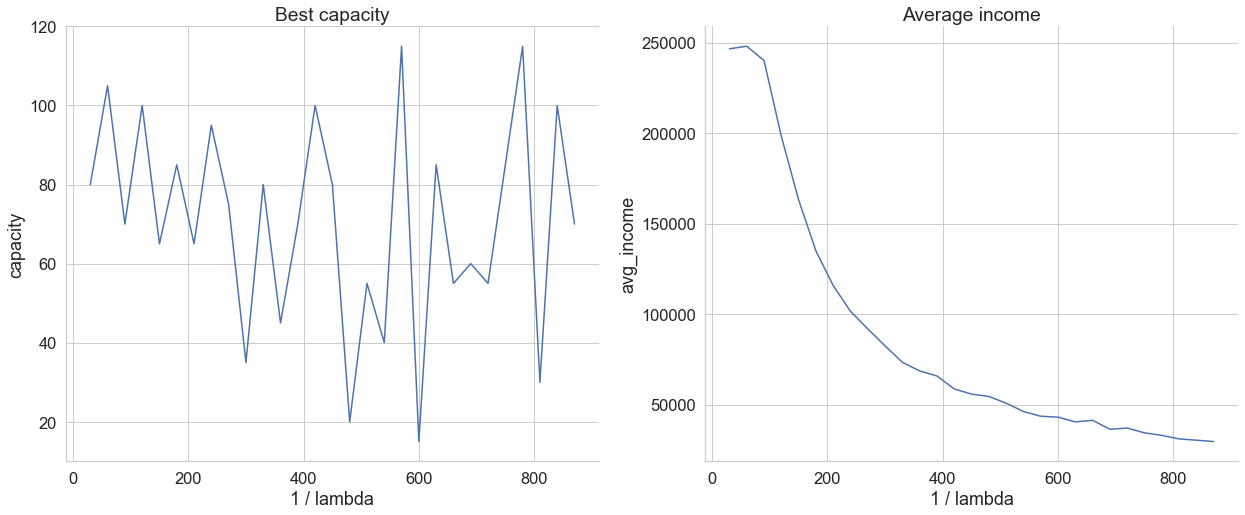

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
sns.lineplot(x=a['lambda'], y=a['capacity'], ax=axs[0])
axs[0].set_xlabel('1 / lambda')
axs[0].set_title('Best capacity')

sns.lineplot(x=a['lambda'], y=a['avg_income'], ax=axs[1])
axs[1].set_xlabel('1 / lambda')
axs[1].set_title('Average income')

sns.despine()
plt.show()

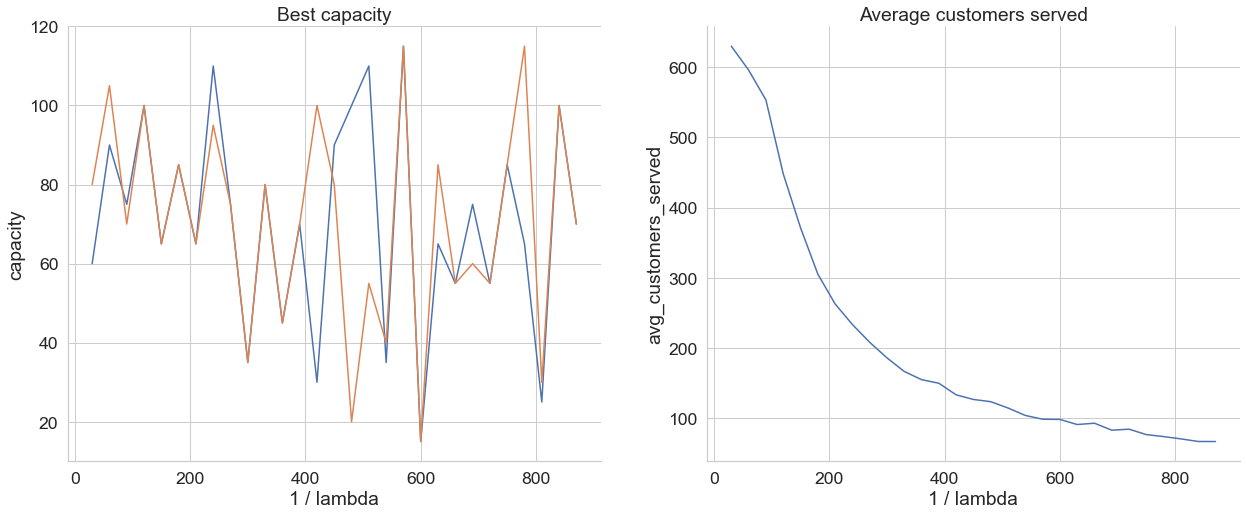

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
sns.lineplot(x=b['lambda'], y=b['capacity'], ax=axs[0])
axs[0].set_xlabel('1 / lambda')
axs[0].set_title('Best capacity')

sns.lineplot(x=b['lambda'], y=b['avg_customers_served'], ax=axs[1])
axs[1].set_xlabel('1 / lambda')
axs[1].set_title('Average customers served')
sns.lineplot(x=a['lambda'], y=a['capacity'], ax=axs[0])

sns.despine()
plt.show()

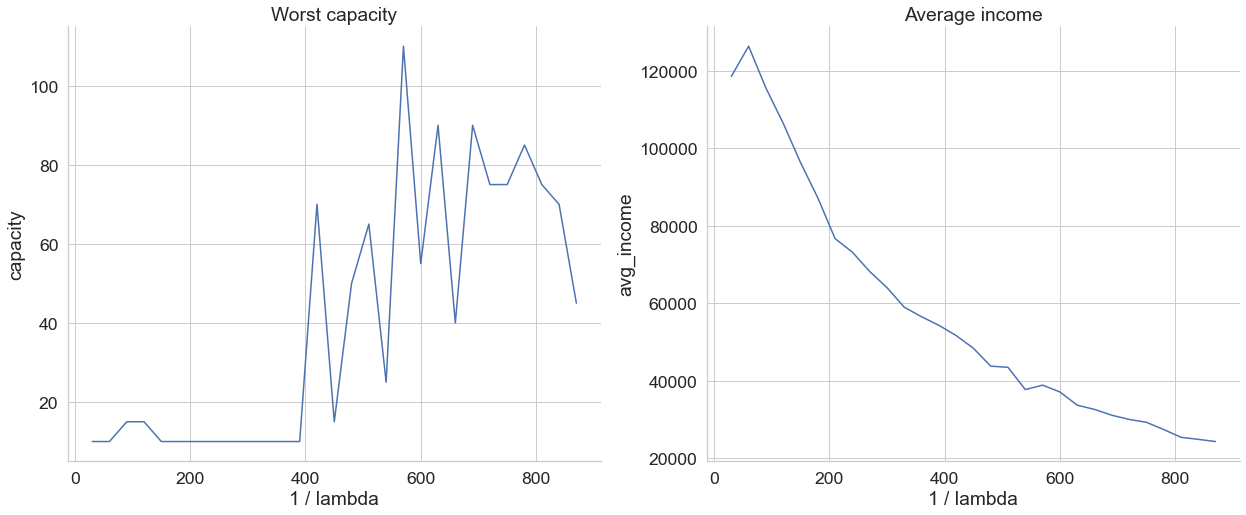

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')
sns.lineplot(x=c['lambda'], y=c['capacity'], ax=axs[0])
axs[0].set_xlabel('1 / lambda')
axs[0].set_title('Worst capacity')

sns.lineplot(x=c['lambda'], y=c['avg_income'], ax=axs[1])
axs[1].set_xlabel('1 / lambda')
axs[1].set_title('Average income')

sns.despine()
plt.show()

Find ice rink workload during open time

In [87]:
all_customers, ice_capacity = simulation(10000, 30, 3, 3, 12 * 60 * 60, 30, 40, False)
customer_data = pd.DataFrame(all_customers)

In [88]:
ice_capacity = ice_capacity[:-32]

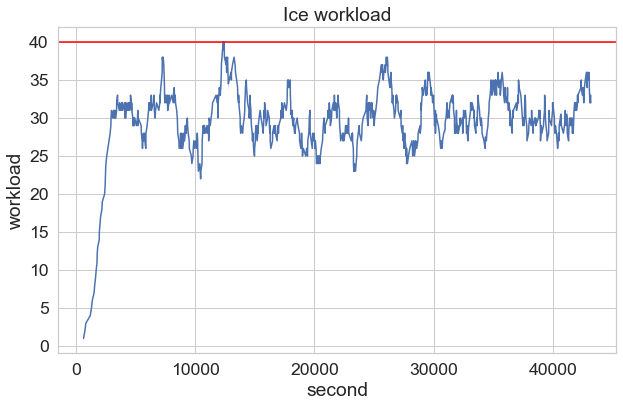

In [92]:
ice = np.array(ice_capacity).T
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')

g = sns.lineplot(x=ice[0], y=ice[1], ax=ax)
ax.set_title('Ice workload')
ax.set_xlabel('second')
ax.set_ylabel('workload')
g.axhline(40, color='red')

plt.show()

In [93]:
customer_data[customer_data['t_on_ice'] == -1].shape[0]

1